In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [2]:
dd = IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");
plot(dd.equilibrium.time_slice[1])
IMAS.flux_surfaces(dd.equilibrium);

In [3]:
# Initialize layers of radial build explicitly
#
# rb=FUSE.init(IMAS.radial_build(),
#     Bmax_OH=11.0,
#     Bmax_TF=5.3,
#     gap_OH=1.0,
#     OH=0.12,
#     inner_TF=0.37,
#     inner_shield=0.01,
#     inner_blanket=0.22,
#     inner_wall=0.01,
#     vacuum_vessel=1,
#     outer_wall=0.01,
#     outer_blanket=0.22,
#     outer_shield=0.01
#     outer_TF=0.37
#     gap_cryostat=0.2
# )

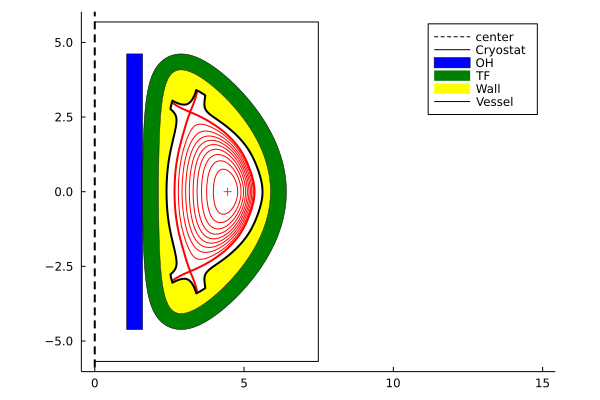

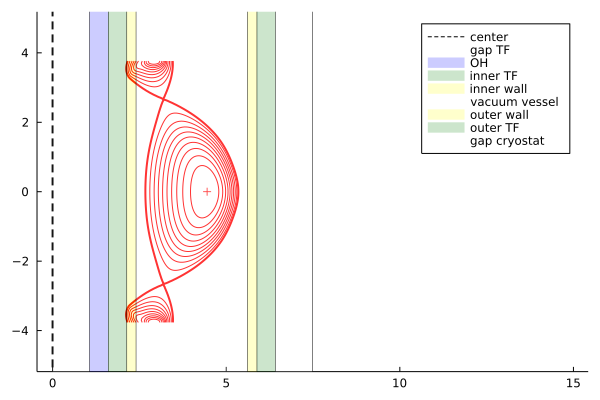

In [184]:
# initialize layers of radial build
rb=IMAS.radial_build()
FUSE.init(rb,dd.equilibrium.time_slice[1],is_nuclear_facility=false)
dd.radial_build=rb
eqt=dd.equilibrium.time_slice[1]

function xy_polygon(x,y)
    if x[1]≈x[end]
        x[end]=x[1]
        y[end]=y[1]
    elseif x[1]!=x[end]
        push!(x,x[1])
        push!(y,y[1])
    end
    coords = [collect(map(collect,zip(x,y)))]
    polygon = LibGEOS.Polygon(coords)
end

function join_paths(r1,z1,r2,z2)
    i1=1
    i2=argmin((r2.-r1[i1]).^2+(z2.-z1[i1]).^2)
    p(x1,x2)=vcat(x1,x2[i2:end],x2[1:i2],x1[i1])
    return p(r1,r2),p(z1,z2)
end

function xy_polygon(r1,z1,r2,z2)
    return xy_polygon(join_paths(r1,z1,r2,z2)...)
end

function miller(R0,epsilon,kappa,delta,n)
    θ = range(0,2pi,length=n)
    δ₀ = asin(delta)
    x = R0*(1 .+ epsilon .* cos.(θ .+ δ₀*sin.(θ)))
    y = R0*(epsilon*kappa*sin.(θ))
    return (x,y)
end

function wall_miller_conformal(rb,layer_id,elongation,triangularity)
    layer_id=-abs(layer_id)
    Rstart_outer=IMAS.get_radial_build(rb, -layer_id).start_radius
    Rend_outer=IMAS.get_radial_build(rb, -layer_id).end_radius
    if layer_id==-1
        outer_line=miller((Rend_outer+Rstart_outer)/2.0,(Rend_outer-Rstart_outer)/(Rend_outer+Rstart_outer),elongation,triangularity,100)        
        return outer_line,outer_line
    else
        Rstart_inner=IMAS.get_radial_build(rb, layer_id).start_radius
        Rend_inner=IMAS.get_radial_build(rb, layer_id).end_radius
        inner_line=miller((Rstart_outer+Rend_inner)/2.0,(Rstart_outer-Rend_inner)/(Rstart_outer+Rend_inner),elongation,triangularity,100)
        outer_line=miller((Rend_outer+Rstart_inner)/2.0,(Rend_outer-Rstart_inner)/(Rend_outer+Rstart_inner),elongation,triangularity,100)
        return inner_line,outer_line
    end
end

function wall_plug(rb::IMAS.radial_build)
    L=0
    R=IMAS.get_radial_build(rb, 1).start_radius
    U=maximum(IMAS.get_radial_build(rb, -2).outline.z)
    D=minimum(IMAS.get_radial_build(rb, -2).outline.z)
    return [L,R,R,L,L],[D,D,U,U,D]
end

function wall_oh(rb::IMAS.radial_build)
    L=IMAS.get_radial_build(rb, 1).start_radius
    R=IMAS.get_radial_build(rb, 1).end_radius
    U=maximum(IMAS.get_radial_build(rb, -2).outline.z)
    D=minimum(IMAS.get_radial_build(rb, -2).outline.z)
    return [L,R,R,L,L],[D,D,U,U,D]
end

function wall_cryostat(rb::IMAS.radial_build)
    L=0
    R=rb.center_stack[end].end_radius
    U=maximum(IMAS.get_radial_build(rb, -2).outline.z)+rb.center_stack[end].thickness
    D=minimum(IMAS.get_radial_build(rb, -2).outline.z)-rb.center_stack[end].thickness
    return [L,R,R,L,L],[D,D,U,U,D]
end

using LibGEOS
using Interpolations
using Contour
using PolygonOps
using StaticArrays

δψ=0.05

# we make the outer wall to be conformal to miller
inner_wall_line, outer_wall_line=wall_miller_conformal(rb,5,eqt.boundary.elongation,eqt.boundary.triangularity) # wall
wall_poly = xy_polygon(outer_wall_line...)
if false
    vessel_poly = LibGEOS.buffer(wall_poly,-IMAS.get_radial_build(rb, 5).thickness)
else
    r = range(eqt.profiles_2d[1].grid.dim1[1], eqt.profiles_2d[1].grid.dim1[end], length=length(eqt.profiles_2d[1].grid.dim1))
    z = range(eqt.profiles_2d[1].grid.dim2[1], eqt.profiles_2d[1].grid.dim2[end], length=length(eqt.profiles_2d[1].grid.dim2))
    PSI_interpolant = Interpolations.CubicSplineInterpolation((r, z), eqt.profiles_2d[1].psi)

    # Inner/outer radii of the vacuum vessel
    R_inner_vessel=IMAS.get_radial_build(rb, -1).start_radius
    R_outer_vessel=IMAS.get_radial_build(rb, -1).end_radius
    psi_vessel_trace=(eqt.global_quantities.psi_boundary-eqt.global_quantities.psi_axis)*(1+δψ)+eqt.global_quantities.psi_axis

    # Trace contours of psi on the inner radii and use those contours as the shape of the vacuum vessel.
    cl = Contour.contour(r,z,eqt.profiles_2d[1].psi,psi_vessel_trace)
    distances=[]
    for line in Contour.lines(cl)
        pr, pz = Contour.coordinates(line)
        push!(distances,minimum(sqrt.((pr.-R_inner_vessel).^2 + (pz.-0.0).^2)))
    end
    inner_vessel_line = Contour.coordinates(Contour.lines(cl)[argmin(distances)])
    outer_vessel_line = Contour.coordinates(Contour.lines(cl)[argmax(distances)])
    inner_vessel_line[1].+=(R_inner_vessel-inner_vessel_line[1][argmin(abs.(inner_vessel_line[2]))])
    outer_vessel_line[1].+=(R_outer_vessel-outer_vessel_line[1][argmin(abs.(outer_vessel_line[2]))])

    if sign(inner_vessel_line[2][1])!=sign(outer_vessel_line[2][1])
        vessel_line=[vcat(inner_vessel_line[1],outer_vessel_line[1]),
                     vcat(inner_vessel_line[2],outer_vessel_line[2])]
    else
        vessel_line=[vcat(inner_vessel_line[1],reverse(outer_vessel_line[1])),
                     vcat(inner_vessel_line[2],reverse(outer_vessel_line[2]))]
    end
    vessel_poly=xy_polygon(vessel_line...)

    # make the divertor domes in the vessel
    cl = Contour.contour(r,z,eqt.profiles_2d[1].psi,eqt.global_quantities.psi_boundary*(1-δψ)+eqt.global_quantities.psi_axis*δψ)
    for line in Contour.lines(cl)
        pr, pz = Contour.coordinates(line)
        if pr[1]!=pr[end]
            vessel_poly=LibGEOS.difference(vessel_poly,xy_polygon(pr,pz))
        end
    end
    
    # cut the top/bottom part of the vessel with the inner_wall_line
    vessel_poly=LibGEOS.intersection(vessel_poly,xy_polygon(inner_wall_line...))
end

IMAS.get_radial_build(rb, -1).outline.r = [v[1] for v in LibGEOS.coordinates(vessel_poly)[1]]
IMAS.get_radial_build(rb, -1).outline.z = [v[2] for v in LibGEOS.coordinates(vessel_poly)[1]]

IMAS.get_radial_build(rb, -5).outline.r = [v[1] for v in LibGEOS.coordinates(wall_poly)[1]]
IMAS.get_radial_build(rb, -5).outline.z = [v[2] for v in LibGEOS.coordinates(wall_poly)[1]]

for (k,layer) in reverse(collect(enumerate(rb.center_stack)))
    if (layer.index<-1) && (layer.index>-5)
        poly=LibGEOS.buffer(xy_polygon(rb.center_stack[k+1].outline.r,rb.center_stack[k+1].outline.z),layer.thickness)
        rb.center_stack[k].outline.r = [v[1] for v in LibGEOS.coordinates(poly)[1]]
        rb.center_stack[k].outline.z = [v[2] for v in LibGEOS.coordinates(poly)[1]]
    end
end

IMAS.get_radial_build(rb, 1).outline.r,IMAS.get_radial_build(rb, 1).outline.z = wall_oh(rb)
IMAS.get_radial_build(rb, 0).outline.r,IMAS.get_radial_build(rb, 0).outline.z = wall_plug(rb)
rb.center_stack[end].outline.r,rb.center_stack[end].outline.z = wall_cryostat(rb)


plot(dd.equilibrium.time_slice[1],psi_levels=11,psi_levels_out=[],color=:red)
display(plot!(dd.radial_build,outline=true))

plot(dd.equilibrium.time_slice[1],psi_levels=11,psi_levels_out=[],color=:red)
display(plot!(dd.radial_build,outline=false))

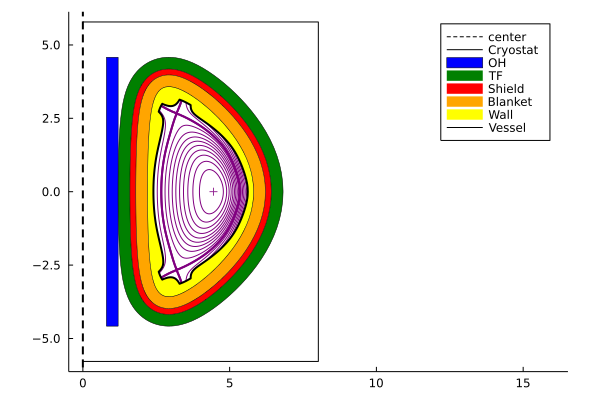

In [191]:
rb=IMAS.radial_build()
eqt=dd.equilibrium.time_slice[1]
FUSE.init(rb,eqt,is_nuclear_facility=true)
plot(eqt,color=:purple)
plot!(rb)

In [58]:
rb;

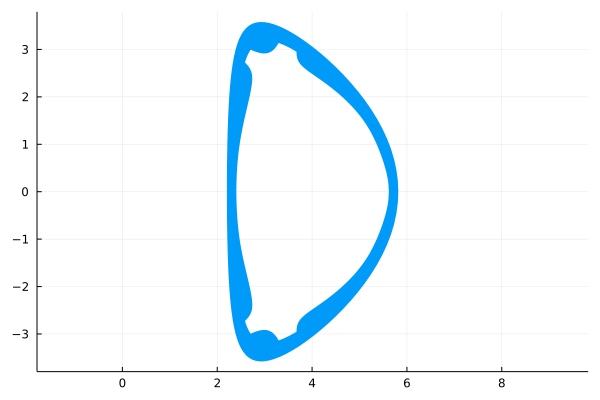

In [82]:
n=6
r1=rb.center_stack[n].outline.r
z1=rb.center_stack[n].outline.z
r2=rb.center_stack[n+1].outline.r
z2=rb.center_stack[n+1].outline.z


#plot(r1,z1,aspect=:equal)
#plot!(r2,z2,aspect=:equal,xlim=[0,6])

function xy_polygon(r1,z1,r2,z2)
    i1=1
    i2=argmin((r2.-r1[i1]).^2+(z2.-z1[i1]).^2)
    p(x1,x2)=vcat(x1,x2[i2:end],x2[1:i2],x1[i1])
    return xy_polygon( p(r1,r2), p(z1,z2))
end

plot(
    , lw=0)
#scatter!([r1[i1]],[z1[i1]])
#scatter!([r2[i2]],[z2[i2]])
